# Calculating $k_{A,R}$ for 1b

The kinetic data for the unsubstituted reactant was not reported in the 2006 paper but is presented in work from 2002. The experiment was also reported at a different temperature (293K) so we will have to recalulate all the rates for 313K. 

The data was found in the supplemental material for...

"The First Kinetic Evidence for Acid Catalysis in a Monocyclic Rearrangement of Heterocycles:  Conversion of the Z-Phenylhydrazone of 5-Amino-3-benzoyl-1,2,4-oxadiazole into N,5-Diphenyl-2H-1,2,3-triazol-4-ylurea." B. Cosimelli, V. Frenna, S. Guernelli, C.Z. Lanza, G. Macaluso, G. Petrillo, D. Spinelli, J. Org. Chem., 2002, 67, 8010-8018. https://doi.org/10.1021/jo026039z

The data was entered into a csv file titled "1b-data_thermo.csv"

We will calulate the rates using the Erying equation

$$k = \frac{\kappa k_B T}{h}e^{\frac{\Delta S^{\ddagger}}{R}}e^{\frac{-\Delta H^{\ddagger}}{RT}}$$

Then we will export the columns of $pS^+$ and $k_{(A,R)}\times 10^5$ to a csv file named "1b-data_calc.csv"

This file will be edited and annotated using a text editor and saved as "1b-data.csv"



In [ ]:
##############################################################
### Set up libraries and global variables
##############################################################

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.constants as constants  # a collection of scientific constants
from scipy.optimize import curve_fit

!pip install uncertainties

import uncertainties as un
from uncertainties import unumpy as unp

github_location = "https://raw.githubusercontent.com/blinkletter/4410PythonNotebooks/main/Class_23/data/"
github_location = "./data/"
github_location_styles = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/styles/"
github_location_LFER_tables = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/data/"

#################################################################
### a function calculate rsq for data and a model with parameters
#################################################################

def rsq(x, y, popt, model):
    ### RSQ calc from https://stackoverflow.com/questions/19189362/getting-the-r-squared-value-using-curve-fit
    y_calc = model(x, *popt)
    residuals = y-y_calc
    
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y-np.mean(y))**2)
    r_squared = 1 - (ss_res / ss_tot)   # calculate correlation constant rsq
    return(r_squared)


## Plot of Calculated rates at 313K vs Observed Rates at 293 K

We have data for the reaction in the same condition but at 20 deg C. from another paper. The same paper reports the thermodynamic parameters (very low precision, from 3-point Eyring plots). We can calculate the rates at 313K and use them directly to get the kinetic parameters of the pH-rate profile at 313K. 

First let us check that the calculations relate to the observations. In the code below I will calculate the rates at 298K from the $\Delta H^\ddagger$ and $\Delta S^\ddagger$ valyes reported in the paper. Set `T = 298` in the code below and run it. 

We observe that the intercept is near zero, indicating that the calculated and observed rates are nearly identical, on average. We do observe a significant scatter in the data due to the low precision of the thermodynamic parameters (one sig fig sometimes - ouch!). Perhaps, rather than use the individual thermodynamic parameters to create a pH-rate profile at 313K, we could create a calibration curve and then use that to convert the observed rates at 298K to rates at 313K using a correction factor that is based on the average increase in rate across all the data points. 

Now change the temperature in the code below to 313K by setting `T = 313`. After we run the code we see that the intercept is 1.02 and so we can say that the reation rates are 10.6 $\times$ faster when we calculate the rates at 313K. So we can use a calibration factor of 10.6 as the average increase in rate across the pH-rate profile.

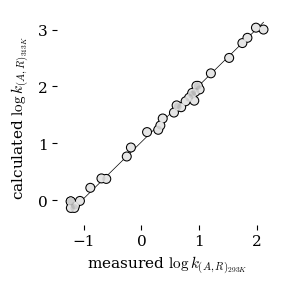

The slope of the log-log plot is 1.000
the intercept is 1.023+/-0.013

Therefore the calculated rates are (on average) 10.55+/-0.30 times faster


In [40]:
##############################################################
### CHANGE THIS: choose temperature for caluclated rates
##############################################################

T = 313

datafile_name = "1b-data_thermo.csv"

##############################################################
### Read data for thermodynamic parameters
##############################################################

df = pd.read_csv(github_location + datafile_name, 
             delimiter = ",", 
             skipinitialspace=True, 
             index_col="pS+", 
             comment = "#") 

##############################################################
### calculate rate constants using Eyring equation
##############################################################

### Set up constants

kappa = 1
kB = constants.Boltzmann
h = constants.h
R = constants.R
delta_H = df["delta_H"]*1000
delta_S = df["delta_S"]

### rename the result column in the data set to indicate that it is the measured data from the paper
df.rename(columns={"k(A,R)x10^5":"k(A,R)x10^5_measured"}, inplace = True)

### Calculate the rate constants using the Eyring equation
df["k(A,R)x10^5_Erying"] = (kappa * kB * T / h) * np.exp(delta_S / R) * np.exp(-delta_H / (R * T)) * 1E5

### Pull x and y data from the dataframe
x = np.log10(df["k(A,R)x10^5_measured"])
y = np.log10(df["k(A,R)x10^5_Erying"])

##############################################################
### Perform a linear regression line fit of x and y
### Use the boolean flags to choose between a linear fit with
### slope enforced to be 1.000 or to use a linear regression 
### optimized both slope and intercept.
##############################################################

if True:    # Force slope to 1.0

    def model1(x, int):    
        y = 1.0*x + int
        return(y)

    parameters, pcov = curve_fit(model1, x, y)

    param = un.correlated_values(parameters, pcov)

    [intercept] = param        ### Assign the parameter list to values
    slope = 1.0
    
if False:  # use tradition linear reghression to fit bot slope and intercept

    fit = stats.linregress(x,y)    ### This is the line fit
    
    slope = fit.slope
    intercept = fit.intercept

##############################################################
### Create a line to plot from the slope and intercept
##############################################################

start = np.min(x)
finish = np.max(x)
x1 = np.linspace(start, finish, 10)
fity = slope*x1 + intercept.n

##############################################################
### Output plot and results
##############################################################

### Set plot style
style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

### Set figure layout (fig) that contains the plot (ax)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3,3))  

### Set margins around the plot (ax)
ax.margins(x=.07, y=.07, tight=True)

### Set axis labels and ranges for the plot (ax)
ax.set(
#    title="None",
          ylabel=r"calculated $\log{k_{(A,R)_{313K}}}$", 
          xlabel=r"measured $\log{k_{(A,R)_{293K}}}$", 
#          xlim=[-.9,.9], 
#          ylim=[-3.7,-2.7]
         )

### Plot the line fit. (zorder = 3 will be in front of zorder = 1)
ax.plot(x1, fity, color='black', zorder=1, linewidth=0.5)

### Plot the data as a series of stacked data points
ax.scatter(x,y, s=52, color="black", marker='o', edgecolors = "none", zorder=3)
ax.scatter(x,y, s=32, color="white", marker='o', edgecolors = "none", zorder=3)
ax.scatter(x,y, s=32, color="black", marker='o', edgecolors = "none", alpha = 0.1, zorder=3)

### Save the figure containing the plot and show the plot in this notebook]
fig.savefig("images/plot_1b_calc.pdf")   # use this to save the figure in PDF format
plt.show()

### Display the results
print(f"The slope of the log-log plot is {slope:0.3f}")
print(f"the intercept is {intercept:0.3f}")
print()
print(f"Therefore the calculated rates are (on average) {10**intercept:0.2f} times faster")


## Conversion of rates from 293.15K to 313.15K

I could take the $k_{(A,R)}\times 10^5$ that were calculated at 313K from the thermodynamic parameters and use them in a curve fit of the pH-rate profile. The calculated data is a bit choppy compared to the measured data. The thermodynamic values of $\Delta H^\ddagger$ and $\Delta S^\ddagger$ were reported to only two digits of precision.   

On average across the range of pH values the reaction at 313K is 10.6 $\times$ faster than the reaction at 293K as determined from the slope of the line of calculated vs measured rates.

So for a better plot we will export our adjusted rate data by multiplying the rates at 293K by 10.6 to get the rates at 313K.

The code below will take the experimental data at 293K and multiply by the calibration constant for the new temperature at 313K.

In [38]:
##############################################################
### make dataset for substituent = H data at 313K (calculated from 213K data set)
##############################################################

### The factor to multiply rates was determined above
factor = 10**intercept.n

### make a column with the same naming convention as all the other data sets
df["k(A,R)x10^5"] = df["k(A,R)x10^5_measured"] * factor

### Create a new dataframe with only the information needed
df2 = df[['k(A,R)x10^5', 'BUFFER']]

### Write that new dataframe out as a data file
filename = "1b-data2.csv"
df2.to_csv("./data/" + filename, float_format="%0.2f")

#display(df2)

## Plotting the Two calculated Result Together

Above we produced a plot of the calculated results at $313K$ from activation parameters and the recorded rates at $293K$.  The intercept would be the difference in magnitude between the two lines and resulted in a conversion factor of $10.66$

The code below generates a plot of the pH-rate profile using both the rate constants calculated for 313K from activation parameters and the rate constants calculated for 313K using the factor of 10.6 applied to the experimental rates at 293K.

We see that both data sets produce very similar values. I will be using the data set for the pH-rate profile generated using the multiplication factor for the rate in the subsequent analyses.

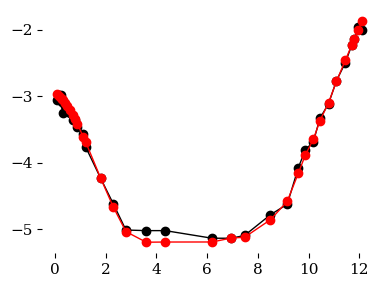

In [39]:
pH = df.index     # pH values are the index column of the dataframe

y_byEyring = np.log10(df["k(A,R)x10^5_Erying"]/100000)
y_byfactor = np.log10(df2["k(A,R)x10^5"]/100000)

plt.plot(pH,y_byEyring,"o-k")   # plot circles for points, a line, black
plt.plot(pH,y_byfactor,"o-r")

## Fancy Plot

The plot below is just the one above but with lots of style added. 

Parameters for curve fit to kobs calculated from ACTIVATION PARAMETERS
Ka = 0.47+/-0.13 
kOH = 1.28+/-0.07 
kH2O = (8.04+/-0.66)E-06 
kH = 0.00154+/-0.00028 
pKa = 0.33+/-0.12
kH/Ka = 0.00327+/-0.00036
Parameters for curve fit to kobs calculated from EXPERIMENTAL DATA
Ka = 0.56+/-0.10 
kOH = 1.30+/-0.05 
kH2O = (6.54+/-0.34)E-06 
kH = 0.00189+/-0.00024 
pKa = 0.25+/-0.08
kH/Ka = 0.00337+/-0.00022


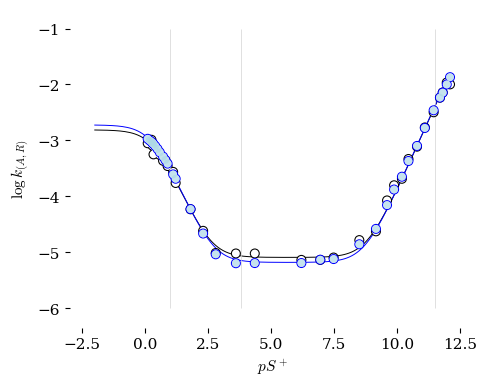

In [41]:
def model(pH, Ka = -1.0, kOH=1.0, kH2O = 1.0, kH = 1.0):    
    """
    model(x, Ka, kOH, kH2O, kH)
    pH is an array of pH values
    returns an array of log(k_obs) values
    """
    KW = 10**(-14)
    H = 10**(-pH)
    k_obs = (kOH * (KW/H) + kH2O + kH * (H/Ka))*(Ka/(Ka + H))
    return(np.log10(k_obs))


#####################################################
### Get series of data to plot from the dataframe 
#####################################################

x = pH
y1 = y_byEyring
y2 = y_byfactor


##################################################
### Setup a figure and choose a stylesheet     
##################################################

style_file = "tufte.mplstyle"
plt.style.use(github_location_styles + style_file)        

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))  
ax.margins(x=.07, y=.07, tight=True)      # add 7% empty space around outside of plot area   

############################
### Set labels and scale 
############################

ax.set(
#    title="pH rate profilr",       
          ylabel=r"$\log{k_{(A,R)}}$", 
          xlabel=r"$pS^+$",                
#          xlim=[-.25,.2],                  
#          ylim=[-6,-1]
         )


plt.vlines([1,3.8,11.5],-6,-1, colors = "lightgray", linewidth = 0.5)


##################################################
### Curve Fits                                
##################################################

################################################################
### Set the flag to Tru to add line fit for the pH-profile
### that was calculated from experimental parameters
################################################################

if True:

    ### Set bounds so rate constants are never negative and constrain Ka value if needed
    min_Ka = 0.01
    max_Ka = 10       # One data set will want infinite Ka value because of no curvature in that region. Limit max value.
    k_min = 0
    k_max = np.inf

    lower_bounds = [min_Ka, k_min, k_min, k_min]    # lower bounds for Ka, kOH, kH2O, kH
    upper_bounds = [max_Ka, k_max, k_max, k_max] # upper bounds for Ka but no upper bounds for kOH, kH2O, kH
    bounds_list = (lower_bounds, upper_bounds)

    ### Perform the curve fit. Will return a list of parameters and an array of statistical info.
    parameters, pcov = curve_fit(model, x, y1, bounds = bounds_list)  # Curve fit the model to the x,y data using bounding limits

    param = un.correlated_values(parameters, pcov)

    [Ka, kOH, kH2O, kH] = param        ### Assign the parameter list to values
    
    print("Parameters for curve fit to kobs calculated from ACTIVATION PARAMETERS")

    ################################################################
    ### make a line from the parameters and the model            
    ### this would be the line of the curve fit when plotted     
    ################################################################

    step = 0.1
    #x1 = np.arange(np.min(x), np.max(x)+step, step)
    x1 = np.arange(-2, 12 + step, step)     # make an array of points to calculate y-values from
    fity = model(x1, *parameters)     # Calculate those y-values using the model

    #########################################
    ### Plot the line fit.                
    #########################################
    if True:
        ax.plot(x1, fity, color='black', zorder=0, linewidth=0.7)

        #######################################################
        ### Print out Parameters and standard deviations    
        #######################################################

        print(f"Ka = {Ka:0.2G} ")
        print(f"kOH = {kOH:0.3G} ")
        print(f"kH2O = {kH2O:0.3G} ")
        print(f"kH = {kH:0.3G} ")
        print(f"pKa = {-unp.log10(Ka):0.2f}")
        print(f"kH/Ka = {kH/Ka:0.3g}")

################################################################
### Set the flag to Tru to add line fit for the pH-profile
### that was calculated from thermodynamic parameters
################################################################

if True:

    ### Set bounds so rate constants are never negative and constrain Ka value if needed
    min_Ka = 0.01
    max_Ka = 10       # One data set will want infinite Ka value because of no curvature in that region. Limit max value.
    k_min = 0
    k_max = np.inf

    lower_bounds = [min_Ka, k_min, k_min, k_min]    # lower bounds for Ka, kOH, kH2O, kH
    upper_bounds = [max_Ka, k_max, k_max, k_max] # upper bounds for Ka but no upper bounds for kOH, kH2O, kH
    bounds_list = (lower_bounds, upper_bounds)

    ### Perform the curve fit. Will return a list of parameters and an array of statistical info.
    parameters, pcov = curve_fit(model, x, y2, bounds = bounds_list)  # Curve fit the model to the x,y data using bounding limits

    param = un.correlated_values(parameters, pcov)

    [Ka, kOH, kH2O, kH] = param        ### Assign the parameter list to values
    
    print("Parameters for curve fit to kobs calculated from EXPERIMENTAL DATA")


    ################################################################
    ### make a line from the parameters and the model            
    ### this would be the line of the curve fit when plotted     
    ################################################################

    step = 0.1
    #x1 = np.arange(np.min(x), np.max(x)+step, step)
    x1 = np.arange(-2, 12 + step, step)     # make an array of points to calculate y-values from
    fity = model(x1, *parameters)     # Calculate those y-values using the model

    #########################################
    ### Plot the line fit.                
    #########################################
    if True:
        ax.plot(x1, fity, color='blue', zorder=0, linewidth=0.7)
    
        #######################################################
        ### Print out Parameters and standard deviations    
        #######################################################
    
        print(f"Ka = {Ka:0.2G} ")
        print(f"kOH = {kOH:0.3G} ")
        print(f"kH2O = {kH2O:0.3G} ")
        print(f"kH = {kH:0.3G} ")
        print(f"pKa = {-unp.log10(Ka):0.2f}")
        print(f"kH/Ka = {kH/Ka:0.3g}")


################################################################
### Plot Data Points
### Set the flags to plot each set of data points
################################################################

if True:          ### plot data from THERMODYNAMIC PARAMETERS
    ax.scatter(x,y1, s=52, color="black", edgecolors = "none",zorder=2)
    ax.scatter(x,y1, s=32, color="white", edgecolors = "none",alpha = 1.0, zorder=2)

if True:          ### plot data from EXPERIMENTAL RESULTS adjusted for 313K
    ax.scatter(x,y2, s=52, color="blue", edgecolors = "none",zorder=2)
    ax.scatter(x,y2, s=32, color="white", edgecolors = "none", alpha = 1.0, zorder=2)
    ax.scatter(x,y2, s=32, color="lightblue", edgecolors = "none", alpha = 0.7, zorder=2)

#############################
### Output the final plot 
#############################

fig.savefig("images/plot_1b_calc_pH.pdf")   # use this to save the figure in PDF format
plt.show()                 # output the combined plot plots

